In [1]:
import geopandas as gpd
import pandas as pd
from src.overpass_query import query_overpass_candidates_inside_pc4_area



In [2]:
pc4_gdf = gpd.read_file('./data/georef-netherlands-postcode-pc4.geojson')
# filter to zuid-holland
pc4_gdf = pc4_gdf[pc4_gdf['prov_name'] == 'Zuid-Holland']

In [20]:
# get osm chargers
result_gdf = gpd.GeoDataFrame(columns=['pc4_code', 'lat', 'lon'])
# for each pc4 polygon, get the charging points
for i, row in pc4_gdf.iterrows():
    pc4_polygon = row['geometry']
    pc4_code = row['pc4_code']
    print(f'Processing {pc4_code}...')
    
    # get the charging points for this polygon
    charging_points = query_overpass_candidates_inside_pc4_area(pc4_polygon, 
                                                     [("amenity", "charging_station")])
    # add the results to the result_gdf
    for point in charging_points.iterrows():
        point = point[1]
        result_gdf = pd.concat([result_gdf, 
                                    gpd.GeoDataFrame({'pc4_code': [pc4_code], 
                                                      'lat': [point['geometry'].y], 
                                                      'lon': [point['geometry'].x]})],)
result_gdf

Processing 3273...
Processing 3311...


/var/folders/zk/99phrd0d2fs5xjbc622wn4_h0000gn/T/ipykernel_39786/1530906796.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_gdf = pd.concat([result_gdf,


Processing 3319...
Processing 2524...
Processing 2662...
Processing 1428...
Processing 2223...
Processing 2251...
Processing 2267...
Processing 2331...
Processing 2514...
Processing 2517...
Processing 2721...
Processing 2741...
Processing 2802...
Processing 2872...
Processing 2953...
Processing 2988...
Processing 3022...
Processing 3122...
Processing 3208...
Processing 3209...
Processing 3253...
Processing 3318...
Processing 3342...
Processing 3466...
Processing 4202...
Processing 3222...
Processing 2406...
Processing 2408...
Processing 2596...
Processing 2616...
Processing 2636...
Processing 2715...
Processing 2808...
Processing 2821...
Processing 2989...
Processing 2992...
Processing 3039...
Processing 3082...
Processing 3134...
Processing 3151...
Processing 3199...
Processing 3202...
Processing 3204...
Processing 3206...
Processing 3221...
Processing 3232...
Processing 2163...
Processing 2171...
Processing 2204...
Processing 2231...
Processing 2315...
Processing 2402...
Processing 2

pc4_code        lat       lon
0      3311  51.812620  4.666336
0      3311  51.814522  4.668326
0      3311  51.819363  4.674390
0      3311  51.819314  4.670475
0      3311  51.815726  4.660941
..      ...        ...       ...
0      3207  51.845323  4.354212
0      3207  51.832932  4.365328
0      3207  51.836081  4.352667
0      3207  51.832945  4.368563
0      3207  51.836723  4.354683

[9801 rows x 3 columns]

In [21]:
result_gdf = result_gdf.reset_index(drop=True)
result_gdf = gpd.GeoDataFrame(result_gdf, geometry=gpd.points_from_xy(result_gdf['lon'], result_gdf['lat']), crs="EPSG:4326")

In [23]:
result_gdf.to_file('./data/osm-charging_points-zuid-holland.geojson', driver='GeoJSON')

combination

In [3]:
osm_charging_points = gpd.read_file('data/osm-charging_points-zuid-holland.geojson')
osm_charging_points = osm_charging_points.to_crs("EPSG:4326")
ocm_charging_points = gpd.read_file('data/ocm-charging-points-zuid-holland.json')
ocm_charging_points = ocm_charging_points.to_crs("EPSG:4326")

print(f'OSM charging points: {len(osm_charging_points)}')
print(f'OCM charging points: {len(ocm_charging_points)}')

OSM charging points: 9801
OCM charging points: 3072


In [4]:
# combine the two datasets
combined_charging_points = pd.concat([osm_charging_points, ocm_charging_points], ignore_index=True)
combined_charging_points = combined_charging_points.drop_duplicates(subset=['lat', 'lon'])

In [5]:
#convert to EPSG:3857

In [6]:
print(f'Combined charging points: {len(combined_charging_points)}')

Combined charging points: 9478


In [7]:
# find the distance between each pair of points in the combined dataset
from shapely.ops import nearest_points
from shapely.geometry import Point
from pyproj import CRS, Transformer

def generate_closest_points(points_gdf):
    # Convert the GeoDataFrame to a list of points in EPSG:3857
    transformer = Transformer.from_crs(CRS("EPSG:4326"), CRS("EPSG:3857"))
    result_gdf = points_gdf
    def find_nearest_charging_point(point, points_gdf):
        # excluide the point itself from the search
        points_gdf = points_gdf[points_gdf.geometry != point]
        nearest_geom = nearest_points(point, points_gdf.unary_union)[1]
        distance = Point(transformer.transform(point.x, point.y)).distance(Point(transformer.transform(nearest_geom.x, nearest_geom.y)))
        return nearest_geom.x, nearest_geom.y, distance
    result_gdf['nearest_lon'], result_gdf['nearest_lat'], result_gdf["distance_to_nearest"] = zip(*points_gdf.geometry.apply(lambda x: find_nearest_charging_point(x, points_gdf)))
    return result_gdf



combined_charging_points = generate_closest_points(combined_charging_points)

/var/folders/zk/99phrd0d2fs5xjbc622wn4_h0000gn/T/ipykernel_41747/175688910.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nearest_geom = nearest_points(point, points_gdf.unary_union)[1]
/var/folders/zk/99phrd0d2fs5xjbc622wn4_h0000gn/T/ipykernel_41747/175688910.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nearest_geom = nearest_points(point, points_gdf.unary_union)[1]
/var/folders/zk/99phrd0d2fs5xjbc622wn4_h0000gn/T/ipykernel_41747/175688910.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nearest_geom = nearest_points(point, points_gdf.unary_union)[1]
/var/folders/zk/99phrd0d2fs5xjbc622wn4_h0000gn/T/ipykernel_41747/175688910.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nearest_geom = nearest_points(point, points_gdf.unary_union)[1]
/var

In [8]:
combined_charging_points

pc4_code        lat       lon                  geometry  nearest_lon  \
0         3311  51.812620  4.666336  POINT (4.66634 51.81262)     4.666690   
1         3311  51.814522  4.668326  POINT (4.66833 51.81452)     4.670434   
2         3311  51.819363  4.674390  POINT (4.67439 51.81936)     4.676442   
3         3311  51.819314  4.670475  POINT (4.67047 51.81931)     4.670394   
4         3311  51.815726  4.660941  POINT (4.66094 51.81573)     4.661727   
...        ...        ...       ...                       ...          ...   
12862     3141  51.919872  4.266606  POINT (4.26661 51.91987)     4.266611   
12863     3207  51.844650  4.353420  POINT (4.35342 51.84465)     4.352835   
12864     3207  51.837170  4.362710  POINT (4.36271 51.83717)     4.362573   
12869     3207  51.835840  4.367723  POINT (4.36772 51.83584)     4.368563   
12870     3207  51.837238  4.370445  POINT (4.37044 51.83724)     4.367723   

       nearest_lat  distance_to_nearest  
0        51.812183            62.610481  
1        51.813082           284.784694  
2        51.817834           285.505171  
3        51.819346             9.656020  
4        51.815456            92.728445  
...            ...                  ...  
12862    51.919884             1.419009  
12863    51.844610            65.461927  
12864    51.837054            20.017163  
12869    51.832945           335.636482  
12870    51.835840           341.449786  

[9478 rows x 7 columns]

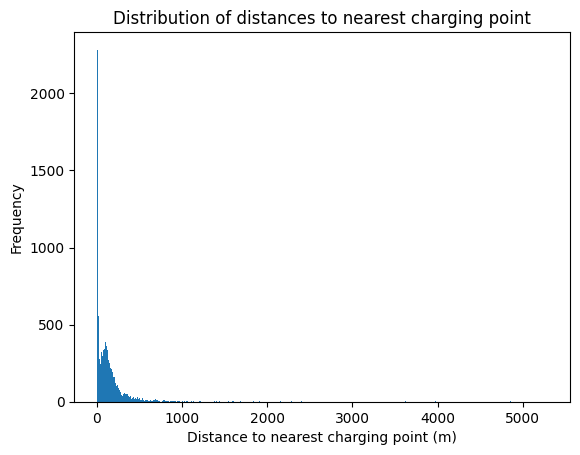

In [9]:
# show the distribution of distances
import matplotlib.pyplot as plt
plt.hist(combined_charging_points['distance_to_nearest'], bins=500)
plt.xlabel('Distance to nearest charging point (m)')
plt.ylabel('Frequency')
plt.title('Distribution of distances to nearest charging point')
plt.show()

In [10]:
# how many point within 2m of each other?
close_points = combined_charging_points[combined_charging_points['distance_to_nearest'] < 2]
print(f'Number of charging points within 2m of each other: {len(close_points)}')

# for each point whose nearest point is within 2m, remove that point, but do not remove the original point
removed_points = gpd.GeoDataFrame(columns=combined_charging_points.columns)
print(removed_points)
for point in close_points.iterrows():
    point = point[1]
    # if nearest_lon and nearest_lat are in the removed_points, skip this point since it has already been removed
    removed_points_check = removed_points[(removed_points['nearest_lon'] == point['lon']) &
                                         (removed_points['nearest_lat'] == point['lat'])]
    if not removed_points_check.empty:
        print(f'Skipping point {point["pc4_code"]} at ({point["lat"]}, {point["lon"]}) since it is already removed.')
        continue
    # otherwise, remove this point
    removed_points = pd.concat([removed_points, gpd.GeoDataFrame({'pc4_code': [point['pc4_code']],
                                                                 'lat': [point['lat']],
                                                                 'lon': [point['lon']],
                                                                 'nearest_lon': [point['nearest_lon']],
                                                                 'nearest_lat': [point['nearest_lat']],
                                                                 'distance_to_nearest': [point['distance_to_nearest']],
                                                                 'geometry': [Point(point['lon'], point['lat'])]})], ignore_index=True) 

removed_points

Number of charging points within 2m of each other: 504
Empty GeoDataFrame
Columns: [pc4_code, lat, lon, geometry, nearest_lon, nearest_lat, distance_to_nearest]
Index: []
Skipping point 3151 at (51.9855128, 4.128258) since it is already removed.
Skipping point 2491 at (52.0670631, 4.3856084) since it is already removed.
Skipping point 2675 at (52.0036962, 4.2318038) since it is already removed.
Skipping point 2512 at (52.0761265, 4.3126994) since it is already removed.
Skipping point 2512 at (52.0761076, 4.3126352) since it is already removed.
Skipping point 2676 at (51.9613736, 4.2201922) since it is already removed.
Skipping point 2676 at (51.9720535, 4.2113027) since it is already removed.
Skipping point 2624 at (52.0007311, 4.35923) since it is already removed.
Skipping point 2624 at (51.9981768, 4.3539866) since it is already removed.
Skipping point 3012 at (51.9162204, 4.4760543) since it is already removed.
Skipping point 3012 at (51.9162972, 4.4760104) since it is already remov

/var/folders/zk/99phrd0d2fs5xjbc622wn4_h0000gn/T/ipykernel_41747/4290193831.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  removed_points = pd.concat([removed_points, gpd.GeoDataFrame({'pc4_code': [point['pc4_code']],


Skipping point 2597 at (52.111343, 4.293838) since it is already removed.
Skipping point 2597 at (52.110042, 4.293448) since it is already removed.
Skipping point 2597 at (52.109774, 4.29642) since it is already removed.
Skipping point 2597 at (52.1089, 4.292752) since it is already removed.
Skipping point 2597 at (52.104843, 4.320224) since it is already removed.
Skipping point 2597 at (52.101789, 4.29907) since it is already removed.
Skipping point 2291 at (52.026233, 4.274278) since it is already removed.
Skipping point 2318 at (52.17827558, 4.49926233) since it is already removed.
Skipping point 2318 at (52.18189718, 4.50151154) since it is already removed.
Skipping point 2584 at (52.098645, 4.278185) since it is already removed.
Skipping point 2584 at (52.104174, 4.272087) since it is already removed.
Skipping point 2584 at (52.09970166, 4.28404956) since it is already removed.
Skipping point 2725 at (52.072498, 4.499875) since it is already removed.
Skipping point 2725 at (52.069

pc4_code        lat       lon                  geometry  nearest_lon  \
0       2524  52.057368  4.313110  POINT (4.31311 52.05737)     4.313108   
1       2524  52.054232  4.311300   POINT (4.3113 52.05423)     4.311313   
2       2524  52.052436  4.312829  POINT (4.31283 52.05244)     4.312840   
3       2514  52.091651  4.302331  POINT (4.30233 52.09165)     4.302333   
4       2514  52.091174  4.306615  POINT (4.30661 52.09117)     4.306622   
..       ...        ...       ...                       ...          ...   
247     2635  52.011938  4.315475  POINT (4.31548 52.01194)     4.315467   
248     2691  51.989453  4.183713  POINT (4.18371 51.98945)     4.183718   
249     3141  51.919884  4.266611  POINT (4.26661 51.91988)     4.266606   
250     2771  52.074059  4.639055  POINT (4.63905 52.07406)     4.639055   
251     2771  52.076065  4.646811  POINT (4.64681 52.07607)     4.646811   

     nearest_lat  distance_to_nearest  
0      52.057372             0.508095  
1      52.054240             1.641433  
2      52.052436             1.250517  
3      52.091655             0.478393  
4      52.091165             1.319472  
..           ...                  ...  
247    52.011954             1.984335  
248    51.989438             1.743042  
249    51.919872             1.419009  
250    52.074060             0.165474  
251    52.076064             0.165960  

[252 rows x 7 columns]

In [11]:
# remove the points from the combined dataset
combined_charging_points = combined_charging_points[~combined_charging_points.geometry.isin(removed_points.geometry)]
print(f'Number of charging points after removing close points: {len(combined_charging_points)}')

Number of charging points after removing close points: 9226


In [12]:
# recalculate the nearest points
combined_charging_points = generate_closest_points(combined_charging_points)
combined_charging_points

/var/folders/zk/99phrd0d2fs5xjbc622wn4_h0000gn/T/ipykernel_41747/175688910.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nearest_geom = nearest_points(point, points_gdf.unary_union)[1]
/var/folders/zk/99phrd0d2fs5xjbc622wn4_h0000gn/T/ipykernel_41747/175688910.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nearest_geom = nearest_points(point, points_gdf.unary_union)[1]
/var/folders/zk/99phrd0d2fs5xjbc622wn4_h0000gn/T/ipykernel_41747/175688910.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nearest_geom = nearest_points(point, points_gdf.unary_union)[1]
/var/folders/zk/99phrd0d2fs5xjbc622wn4_h0000gn/T/ipykernel_41747/175688910.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nearest_geom = nearest_points(point, points_gdf.unary_union)[1]
/var

pc4_code        lat       lon                  geometry  nearest_lon  \
0         3311  51.812620  4.666336  POINT (4.66634 51.81262)     4.666690   
1         3311  51.814522  4.668326  POINT (4.66833 51.81452)     4.670434   
2         3311  51.819363  4.674390  POINT (4.67439 51.81936)     4.676442   
3         3311  51.819314  4.670475  POINT (4.67047 51.81931)     4.670394   
4         3311  51.815726  4.660941  POINT (4.66094 51.81573)     4.661727   
...        ...        ...       ...                       ...          ...   
12862     3141  51.919872  4.266606  POINT (4.26661 51.91987)     4.267293   
12863     3207  51.844650  4.353420  POINT (4.35342 51.84465)     4.352835   
12864     3207  51.837170  4.362710  POINT (4.36271 51.83717)     4.362573   
12869     3207  51.835840  4.367723  POINT (4.36772 51.83584)     4.368563   
12870     3207  51.837238  4.370445  POINT (4.37044 51.83724)     4.367723   

       nearest_lat  distance_to_nearest  
0        51.812183            62.610481  
1        51.813082           284.784694  
2        51.817834           285.505171  
3        51.819346             9.656020  
4        51.815456            92.728445  
...            ...                  ...  
12862    51.919347            96.404898  
12863    51.844610            65.461927  
12864    51.837054            20.017163  
12869    51.832945           335.636482  
12870    51.835840           341.449786  

[9226 rows x 7 columns]

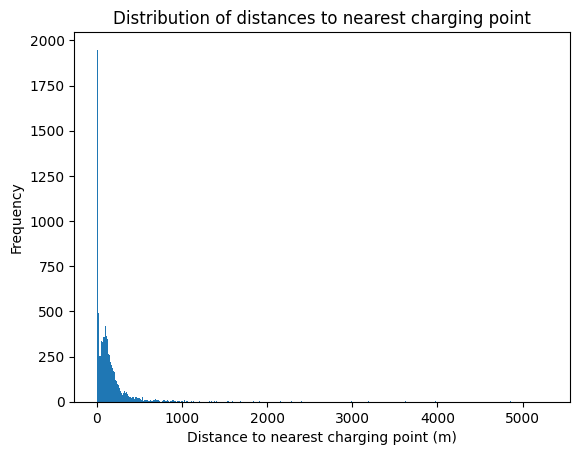

In [13]:
# show the distribution of distances
import matplotlib.pyplot as plt
plt.hist(combined_charging_points['distance_to_nearest'], bins=500)
plt.xlabel('Distance to nearest charging point (m)')
plt.ylabel('Frequency')
plt.title('Distribution of distances to nearest charging point')
plt.show()

In [15]:
# save the combined charging points to a file
combined_charging_points.to_file('./data/combined-charging-points-zuid-holland.geojson', driver='GeoJSON')